In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.path import Path
import cv2
from scipy.ndimage import distance_transform_edt

In [28]:
# 1. Load map and measurement data
map_path = r"Map_of_R1_Hall.png"

img = Image.open(map_path)
width, height = img.size
print(f"Map size: {width}x{height} pixels")

csv_path = r"extracted_points.csv"

df = pd.read_csv(csv_path) #carica il file

# Mostra le prime righe per capire le colonne
#print(df.head())

# Estrai solo X e Y
points = df[['X', 'Y']].values

Map size: 1086x1105 pixels


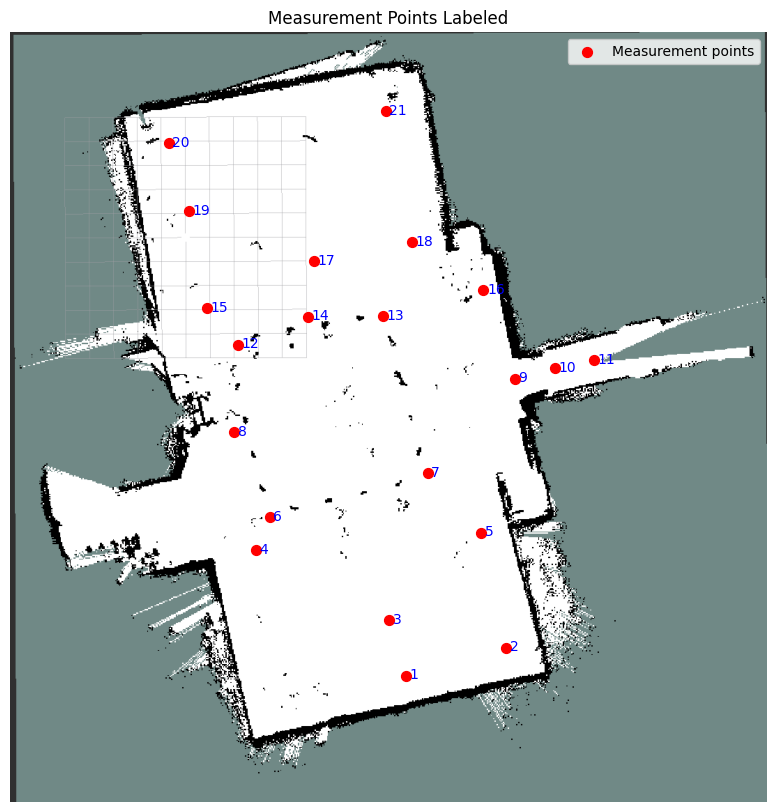

In [29]:
# Plot
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.scatter(df['X'], df['Y'], c='red', s=50, label='Measurement points')

# Label each point with its index
for idx, row in df.iterrows():
    plt.text(row['X'] + 5, row['Y'] + 5, str(row['Index']), color='blue', fontsize=10)

plt.title("Measurement Points Labeled")
plt.axis('off')
plt.legend()
plt.show()

Two closest wall distances: [54.3694983  59.69032755]
Perpendicular points on walls: [[592.15639557 101.57896872]
 [528.45835574  54.24790268]]


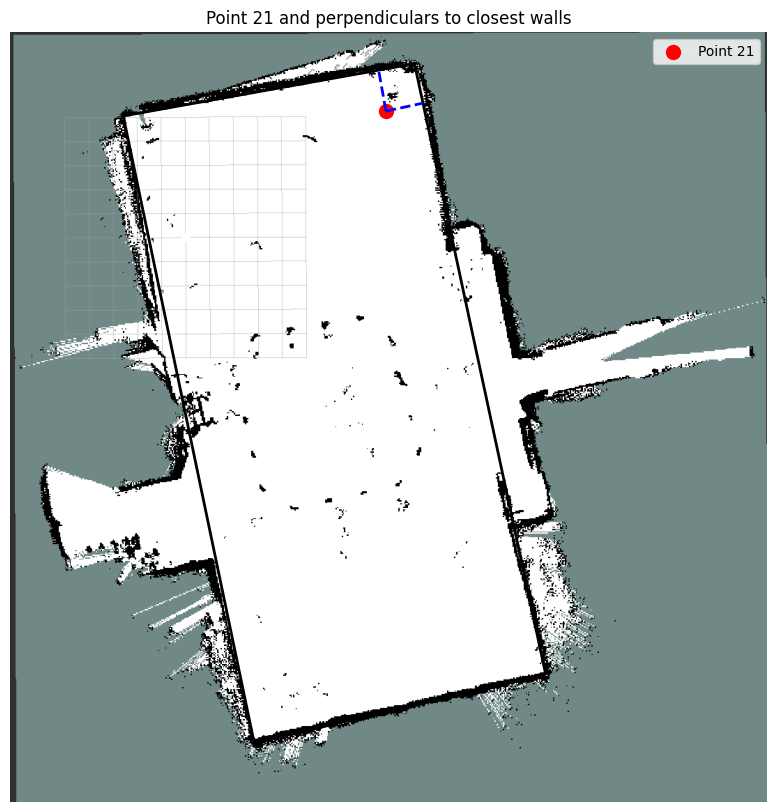

In [30]:
# --- 2) Manually define four wall corners (order roughly clockwise) ---
# Replace these with your actual wall coordinates (x, y in pixels)
walls_corners = np.array([
    [350, 1020],  # bottom-left
    [768, 920],  # bottom-right
    [580, 45],  # top-right
    [162, 120],  # top-left
], dtype=np.int32)

# --- 3) Define wall segments ---
walls = []
for i in range(4):
    start = walls_corners[i]
    end = walls_corners[(i+1) % 4]
    walls.append((start, end))

# --- 4) Function to compute perpendicular distance ---
def point_to_segment_distance(pt, seg_start, seg_end):
    seg_vec = seg_end - seg_start
    pt_vec = pt - seg_start
    seg_len2 = np.dot(seg_vec, seg_vec)
    if seg_len2 == 0:
        return np.linalg.norm(pt - seg_start), seg_start
    t = np.clip(np.dot(pt_vec, seg_vec) / seg_len2, 0, 1)
    projection = seg_start + t * seg_vec
    distance = np.linalg.norm(pt - projection)
    return distance, projection

# --- 5) Example measurement point (Point 21) ---
point_21 = np.array([539, 113])  # X, Y in pixels

# Compute distances to all walls
distances = []
projections = []
for start, end in walls:
    d, proj = point_to_segment_distance(point_21, start, end)
    distances.append(d)
    projections.append(proj)

distances = np.array(distances)
projections = np.array(projections)

# Select two closest walls
closest_idx = np.argsort(distances)[:2]
closest_distances = distances[closest_idx]
closest_projections = projections[closest_idx]

print("Two closest wall distances:", closest_distances)
print("Perpendicular points on walls:", closest_projections)

# --- 6) Visualization ---
plt.figure(figsize=(10,10))
#plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(img)

# Draw walls
for start, end in walls:
    plt.plot([start[0], end[0]], [start[1], end[1]], 'k-', linewidth=2)

# Plot the point
plt.scatter(point_21[0], point_21[1], c='red', s=100, label='Point 21')

# Draw perpendiculars to the two closest walls
for proj in closest_projections:
    plt.plot([point_21[0], proj[0]], [point_21[1], proj[1]], 'b--', linewidth=2)

plt.legend()
plt.axis('off')
plt.title("Point 21 and perpendiculars to closest walls")
plt.show()


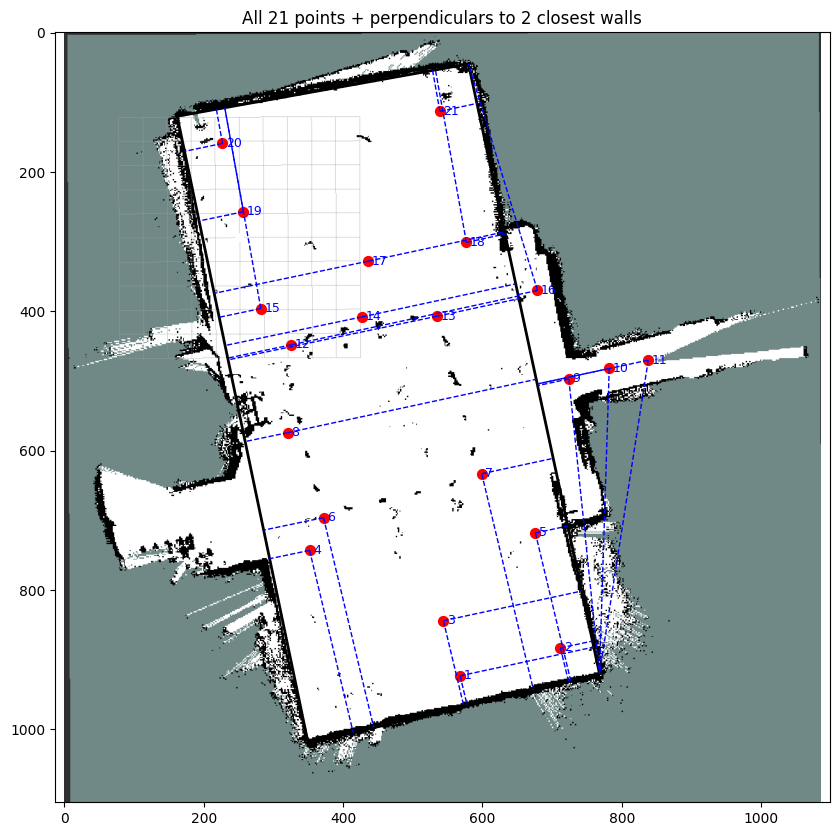

Three closest wall distances from Point 17 [m]: [5.297 6.341 6.696]


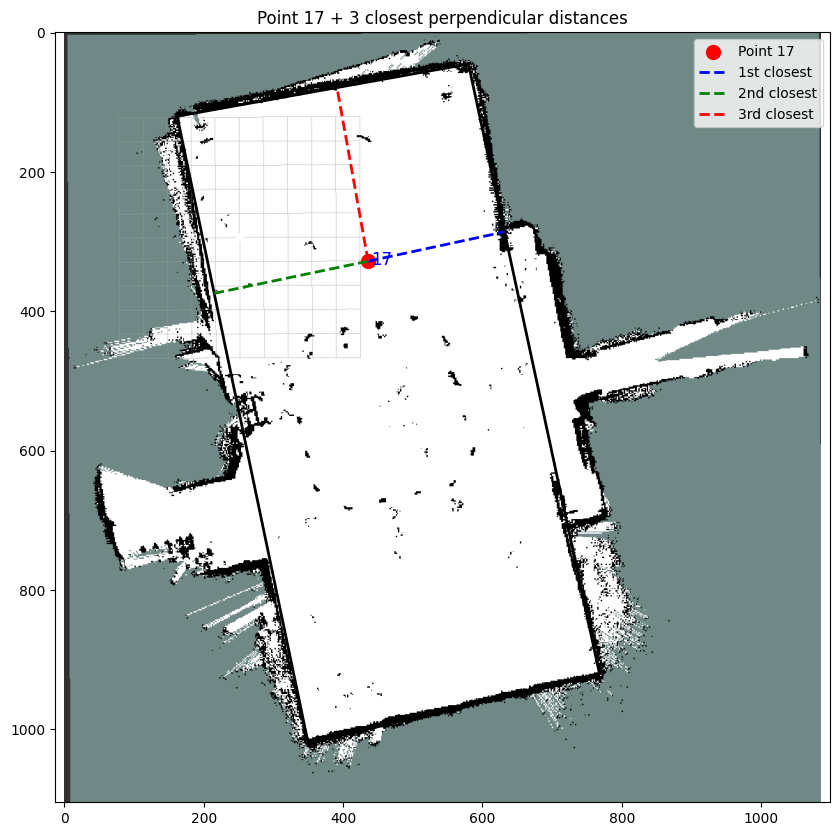

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1) All 21 points ---
points = np.array([
    [568, 923],[712, 883],[544, 844],[352, 743],[676, 718],
    [372, 696],[599, 633],[321, 574],[724, 497],[782, 482],
    [838, 470],[326, 448],[535, 407],[427, 408],[282, 396],
    [679, 370],[436, 328],[577, 301],[257, 257],[227, 159],
    [539, 113]
], dtype=np.int32)

# --- 2) Wall corners (clockwise) ---
walls_corners = np.array([
    [350, 1020],  # bottom-left
    [768, 920],   # bottom-right
    [580, 45],    # top-right
    [162, 120]    # top-left
], dtype=np.int32)

# Build wall segments
walls = [(walls_corners[i], walls_corners[(i+1)%4]) for i in range(4)]
walls_ordered = walls  # alias for clarity

# --- 3) Distance to segment ---
def point_to_segment_distance(pt, seg_start, seg_end):
    seg_vec = seg_end - seg_start
    pt_vec  = pt - seg_start
    seg_len2 = np.dot(seg_vec, seg_vec)
    if seg_len2 == 0:
        return np.linalg.norm(pt - seg_start), seg_start
    t = np.clip(np.dot(pt_vec, seg_vec) / seg_len2, 0, 1)
    projection = seg_start + t * seg_vec
    return np.linalg.norm(pt - projection), projection

# --- 4) Scale definitions for conversion pixels → meters ---
hall_width_m  = 24
hall_height_m = 12
dist_parallel_h = np.linalg.norm((walls_corners[0]+walls_corners[1])/2 - (walls_corners[2]+walls_corners[3])/2)
dist_parallel_v = np.linalg.norm((walls_corners[1]+walls_corners[2])/2 - (walls_corners[3]+walls_corners[0])/2)
scale_x = hall_width_m / dist_parallel_h
scale_y = hall_height_m / dist_parallel_v

# ============================================================
# PART A — Plot all 21 points + perpendiculars
# ============================================================
plt.figure(figsize=(10,10))
plt.imshow(img)

for start, end in walls:
    plt.plot([start[0], end[0]], [start[1], end[1]], 'k-', linewidth=2)

for i, pt in enumerate(points, start=1):
    dists, projs = [], []
    for s, e in walls:
        d, p = point_to_segment_distance(pt, s, e)
        dists.append(d)
        projs.append(p)

    dists = np.array(dists)
    projs = np.array(projs)

    closest = np.argsort(dists)[:2]

    plt.scatter(pt[0], pt[1], c='red', s=50)
    plt.text(pt[0]+5, pt[1]+5, str(i), color='blue', fontsize=9)

    for c in closest:
        pr = projs[c]
        plt.plot([pt[0], pr[0]], [pt[1], pr[1]], 'b--', linewidth=1)

plt.axis('equal')
plt.title("All 21 points + perpendiculars to 2 closest walls")
plt.show()

# --- SELECT POINT 17 ---
pt = points[16]  # Point 17

# Compute distances to all 4 walls
dist_list = []
proj_list = []
for s, e in walls_ordered:
    d, pr = point_to_segment_distance(pt, s, e)
    dist_list.append(d)
    proj_list.append(pr)

dist_list = np.array(dist_list)
proj_list = np.array(proj_list)

# Get 3 closest walls
closest = np.argsort(dist_list)[:3]

# --- Convert to meters (using scale_x and scale_y) ---
closest_m = dist_list[closest].copy()
closest_m[0] *= scale_x
closest_m[1] *= scale_y
closest_m[2] *= scale_x  # oppure scale_y se serve
closest_m = np.round(closest_m, 3)

print("Three closest wall distances from Point 17 [m]:", closest_m)

# --- PLOT ---
plt.figure(figsize=(10,10))
plt.imshow(img)

# Draw walls
for start, end in walls_ordered:
    plt.plot([start[0], end[0]], [start[1], end[1]], 'k-', linewidth=2)

# Draw point 17
plt.scatter(pt[0], pt[1], c='red', s=100, label="Point 17")
plt.text(pt[0]+5, pt[1]+5, "17", color='blue', fontsize=12)

# Draw 3 perpendicular lines
colors = ['blue', 'green', 'red']  # blue=shortest, green=middle, red=longest
labels = ['1st closest', '2nd closest', '3rd closest']

for i, idx in enumerate(closest):
    pr = proj_list[idx]
    plt.plot([pt[0], pr[0]], [pt[1], pr[1]], color=colors[i], linestyle='--', linewidth=2, label=labels[i])

plt.axis('equal')
plt.legend()
plt.title("Point 17 + 3 closest perpendicular distances")
plt.show()


In [32]:
# --- Compute 3 closest wall distances in meters for all points ---
all_distances_m = []

for i, pt in enumerate(points, start=1):
    # compute distances to all walls
    dists = []
    for s, e in walls_ordered:
        d, _ = point_to_segment_distance(pt, s, e)
        dists.append(d)
    dists = np.array(dists)

    # 3 closest walls
    idx = np.argsort(dists)[:3]
    dsel = dists[idx]

    # convert to meters (use scale_x or scale_y depending on wall orientation)
    d_m = []
    for j, wi in enumerate(idx):
        s, e = walls_ordered[wi]
        if abs(s[1]-e[1]) < abs(s[0]-e[0]):  # more horizontal → vertical distance → scale_y
            d_m.append(dsel[j] * scale_y)
        else:  # more vertical → horizontal distance → scale_x
            d_m.append(dsel[j] * scale_x)
    d_m = np.round(d_m, 3)

    all_distances_m.append((i, d_m))

# --- Print nicely ---
for pt_idx, dists in all_distances_m:
    print(f"Point {pt_idx}: {dists}")


Point 1: [1.226 5.19  6.17 ]
Point 2: [ 1.243  1.377 10.116]
Point 3: [3.541 5.371 5.976]
Point 4: [1.55  7.557 9.776]
Point 5: [ 1.257  6.122 10.076]
Point 6: [2.322 8.71  8.998]
Point 7: [2.776 8.948 8.542]
Point 8: [ 1.662  9.639 12.378]
Point 9: [ 1.213 11.95  12.514]
Point 10: [ 2.796 12.314 13.528]
Point 11: [ 4.311 12.797 13.97 ]
Point 12: [2.473 8.809 9.885]
Point 13: [3.176 8.107 9.789]
Point 14: [5.305 5.975 9.28 ]
Point 15: [1.615 8.229 9.658]
Point 16: [ 0.755  9.546 12.036]
Point 17: [5.297 5.97  7.112]
Point 18: [1.5   7.065 9.768]
Point 19: [1.719 4.261 9.533]
Point 20: [1.401 1.472 9.764]
Point 21: [1.438 1.677 9.801]


9 new points well-distributed inside hall:
[[275 219]
 [275 532]
 [465 219]
 [465 532]
 [465 845]
 [654 532]
 [654 845]]


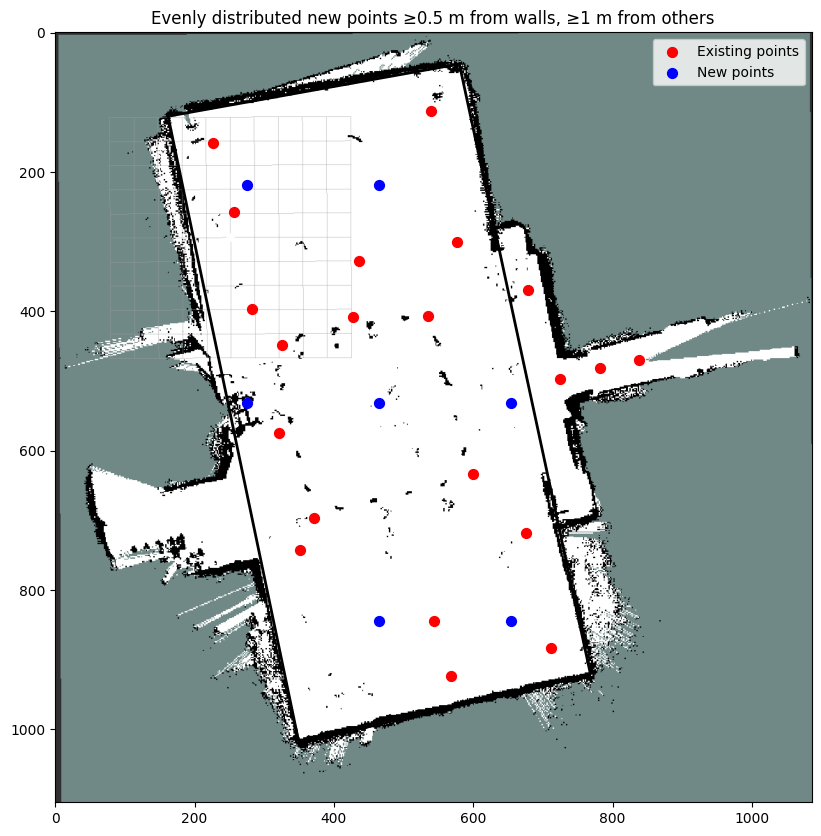

In [33]:

import numpy as np
import matplotlib.pyplot as plt

# Hall corners
walls_corners = np.array([
    [350, 1020],
    [768, 920],
    [580, 45],
    [162, 120]
], dtype=np.int32)

# Existing points
points = np.array([
    [568, 923],[712, 883],[544, 844],[352, 743],[676, 718],
    [372, 696],[599, 633],[321, 574],[724, 497],[782, 482],
    [838, 470],[326, 448],[535, 407],[427, 408],[282, 396],
    [679, 370],[436, 328],[577, 301],[257, 257],[227, 159],
    [539, 113]
], dtype=np.int32)

# Hall dimensions (for pixels/meter conversion)
hall_width_m  = 24
hall_height_m = 12
dist_parallel_h = np.linalg.norm((walls_corners[0]+walls_corners[1])/2 - (walls_corners[2]+walls_corners[3])/2)
dist_parallel_v = np.linalg.norm((walls_corners[1]+walls_corners[2])/2 - (walls_corners[3]+walls_corners[0])/2)
scale_x = hall_width_m / dist_parallel_h
scale_y = hall_height_m / dist_parallel_v

margin_wall_x = 0.5 / scale_x
margin_wall_y = 0.5 / scale_y
min_dist_points = 1 / np.mean([scale_x, scale_y])

# Convex quad check
def inside_quad(pt, quad):
    def sign(p1,p2,p3):
        return (p1[0]-p3[0])*(p2[1]-p3[1]) - (p2[0]-p3[0])*(p1[1]-p3[1])
    b1 = sign(pt, quad[0], quad[1]) < 0
    b2 = sign(pt, quad[1], quad[2]) < 0
    b3 = sign(pt, quad[2], quad[3]) < 0
    b4 = sign(pt, quad[3], quad[0]) < 0
    return ((b1==b2) and (b2==b3) and (b3==b4))

# Grid: divide safe area in 3x3
min_x, max_x = walls_corners[:,0].min() + margin_wall_x, walls_corners[:,0].max() - margin_wall_x
min_y, max_y = walls_corners[:,1].min() + margin_wall_y, walls_corners[:,1].max() - margin_wall_y
grid_x = np.linspace(min_x, max_x, 4)
grid_y = np.linspace(min_y, max_y, 4)

new_points = []
for i in range(3):
    for j in range(3):
        candidate = np.array([int((grid_x[i]+grid_x[i+1])/2), int((grid_y[j]+grid_y[j+1])/2)])
        if inside_quad(candidate, walls_corners):
            if all(np.linalg.norm(points - candidate, axis=1) > min_dist_points):
                new_points.append(candidate)

new_points = np.array(new_points)
print("9 new points well-distributed inside hall:")
print(new_points)

# Plot to verify
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.scatter(points[:,0], points[:,1], c='red', s=50, label='Existing points')
plt.scatter(new_points[:,0], new_points[:,1], c='blue', s=50, label='New points')
plt.plot(np.append(walls_corners[:,0], walls_corners[0,0]),
         np.append(walls_corners[:,1], walls_corners[0,1]), c='black', linewidth=2)
plt.legend()
plt.title("Evenly distributed new points ≥0.5 m from walls, ≥1 m from others")
plt.show()


New points (≥2 m from walls, ≥2 m from others, outside hole):
[[275 219]
 [275 532]
 [465 219]
 [465 845]
 [654 532]
 [654 845]]


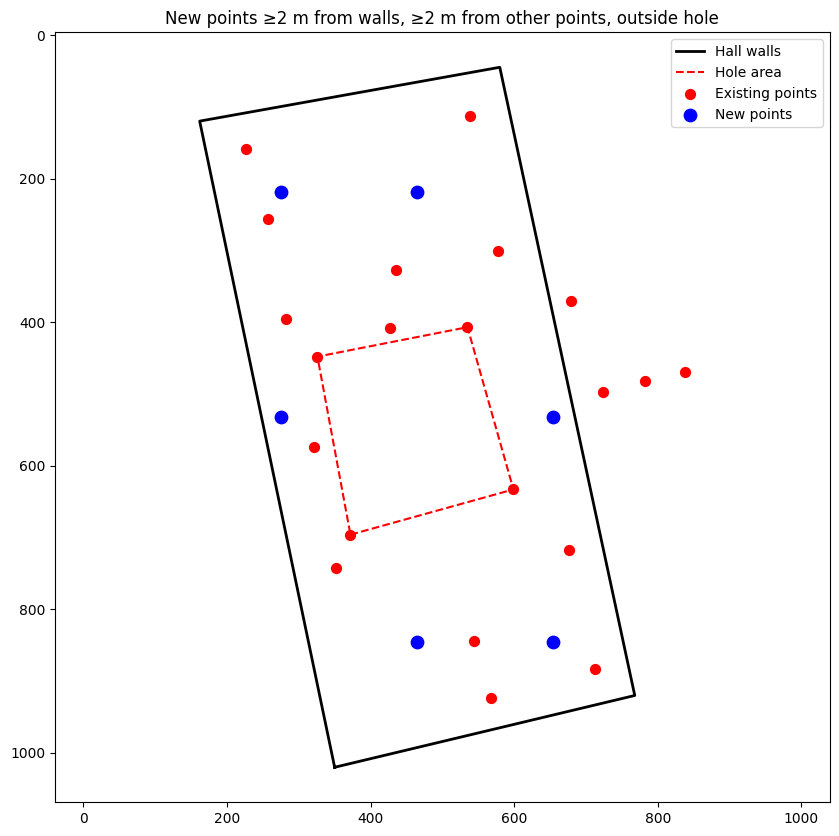

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path

# Hall corners
walls_corners = np.array([
    [350, 1020],
    [768, 920],
    [580, 45],
    [162, 120]
], dtype=np.int32)

# Existing measurement points
points = np.array([
    [568, 923],[712, 883],[544, 844],[352, 743],[676, 718],
    [372, 696],[599, 633],[321, 574],[724, 497],[782, 482],
    [838, 470],[326, 448],[535, 407],[427, 408],[282, 396],
    [679, 370],[436, 328],[577, 301],[257, 257],[227, 159],
    [539, 113]
], dtype=np.int32)

# Hole polygon (inner structure to avoid)
hole_points = np.array([
    [372, 696],
    [599, 633],
    [535, 407],
    [326, 448],
])

# Hall dimensions (for pixels/meter conversion)
hall_width_m  = 24
hall_height_m = 12
dist_parallel_h = np.linalg.norm((walls_corners[0]+walls_corners[1])/2 - (walls_corners[2]+walls_corners[3])/2)
dist_parallel_v = np.linalg.norm((walls_corners[1]+walls_corners[2])/2 - (walls_corners[3]+walls_corners[0])/2)
scale_x = hall_width_m / dist_parallel_h
scale_y = hall_height_m / dist_parallel_v

# 2 m margins
margin_wall_x = 0.5 / scale_x
margin_wall_y = 0.5 / scale_y
min_dist_points = 1 / np.mean([scale_x, scale_y])

# Helper: check if inside convex quad
def inside_quad(pt, quad):
    def sign(p1,p2,p3):
        return (p1[0]-p3[0])*(p2[1]-p3[1]) - (p2[0]-p3[0])*(p1[1]-p3[1])
    b1 = sign(pt, quad[0], quad[1]) < 0
    b2 = sign(pt, quad[1], quad[2]) < 0
    b3 = sign(pt, quad[2], quad[3]) < 0
    b4 = sign(pt, quad[3], quad[0]) < 0
    return ((b1==b2) and (b2==b3) and (b3==b4))

# Hole path
hole_path = Path(hole_points)

# Grid setup
min_x, max_x = walls_corners[:,0].min() + margin_wall_x, walls_corners[:,0].max() - margin_wall_x
min_y, max_y = walls_corners[:,1].min() + margin_wall_y, walls_corners[:,1].max() - margin_wall_y
grid_x = np.linspace(min_x, max_x, 4)
grid_y = np.linspace(min_y, max_y, 4)

# Generate candidate points
new_points = []
for i in range(3):
    for j in range(3):
        candidate = np.array([int((grid_x[i]+grid_x[i+1])/2), int((grid_y[j]+grid_y[j+1])/2)])
        if inside_quad(candidate, walls_corners) and not hole_path.contains_point(candidate):
            if all(np.linalg.norm(points - candidate, axis=1) > min_dist_points):
                new_points.append(candidate)

new_points = np.array(new_points)
print("New points (≥2 m from walls, ≥2 m from others, outside hole):")
print(new_points)

# Visualization
plt.figure(figsize=(10,10))
plt.plot(np.append(walls_corners[:,0], walls_corners[0,0]),
         np.append(walls_corners[:,1], walls_corners[0,1]), 'k-', linewidth=2, label='Hall walls')
plt.plot(np.append(hole_points[:,0], hole_points[0,0]),
         np.append(hole_points[:,1], hole_points[0,1]), 'r--', label='Hole area')

plt.scatter(points[:,0], points[:,1], c='red', s=50, label='Existing points')
plt.scatter(new_points[:,0], new_points[:,1], c='blue', s=80, label='New points')

plt.legend()
plt.title("New points ≥2 m from walls, ≥2 m from other points, outside hole")
plt.gca().invert_yaxis()
plt.axis('equal')
plt.show()


Totale punti: 30
Nuovi punti aggiunti:
[[494 742]
 [427 914]
 [333 162]
 [601 533]
 [504 223]
 [428 119]
 [641 811]
 [346 844]
 [360 263]]


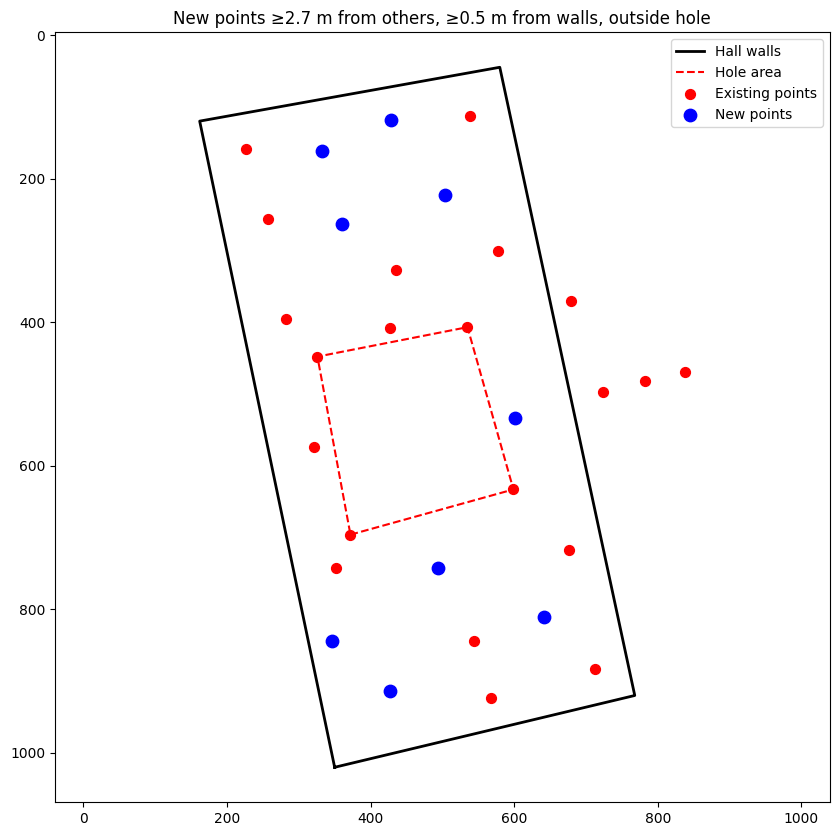

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path

# Hall corners (clockwise)
walls_corners = np.array([
    [350, 1020],
    [768, 920],
    [580, 45],
    [162, 120]
], dtype=np.float64)

# Existing measurement points
points = np.array([
    [568, 923],[712, 883],[544, 844],[352, 743],[676, 718],
    [372, 696],[599, 633],[321, 574],[724, 497],[782, 482],
    [838, 470],[326, 448],[535, 407],[427, 408],[282, 396],
    [679, 370],[436, 328],[577, 301],[257, 257],[227, 159],
    [539, 113]
], dtype=np.float64)

# Hole polygon (inner structure to avoid)
hole_points = np.array([
    [372, 696],
    [599, 633],
    [535, 407],
    [326, 448],
])
hole_path = Path(hole_points)

# Hall dimensions (for pixel/meter conversion)
hall_width_m  = 24
hall_height_m = 12
dist_parallel_h = np.linalg.norm((walls_corners[0]+walls_corners[1])/2 - (walls_corners[2]+walls_corners[3])/2)
dist_parallel_v = np.linalg.norm((walls_corners[1]+walls_corners[2])/2 - (walls_corners[3]+walls_corners[0])/2)
scale_x = hall_width_m / dist_parallel_h
scale_y = hall_height_m / dist_parallel_v
scale = np.mean([scale_x, scale_y])

# Required distances
min_dist_points = 2.7 / scale     # 2.7 m from other points
min_dist_walls = 0.5 / scale      # 0.5 m from walls

# Check if inside convex quad
def inside_quad(pt, quad):
    def sign(p1,p2,p3):
        return (p1[0]-p3[0])*(p2[1]-p3[1]) - (p2[0]-p3[0])*(p1[1]-p3[1])
    b1 = sign(pt, quad[0], quad[1]) < 0
    b2 = sign(pt, quad[1], quad[2]) < 0
    b3 = sign(pt, quad[2], quad[3]) < 0
    b4 = sign(pt, quad[3], quad[0]) < 0
    return ((b1==b2) and (b2==b3) and (b3==b4))

# Distance from point to segment
def point_to_segment_dist(pt, a, b):
    ap = pt - a
    ab = b - a
    t = np.clip(np.dot(ap, ab) / np.dot(ab, ab), 0, 1)
    closest = a + t * ab
    return np.linalg.norm(pt - closest)

# Check distance from all 4 walls
def far_from_walls(pt, walls, min_dist):
    for i in range(len(walls)):
        a, b = walls[i], walls[(i+1)%len(walls)]
        if point_to_segment_dist(pt, a, b) < min_dist:
            return False
    return True

# Bounds for random sampling
min_x, max_x = walls_corners[:,0].min(), walls_corners[:,0].max()
min_y, max_y = walls_corners[:,1].min(), walls_corners[:,1].max()

# Iteratively add points until 30
target_n = 30
max_trials = 20000
np.random.seed(0)

while len(points) < target_n:
    found = False
    for _ in range(max_trials):
        candidate = np.array([
            np.random.uniform(min_x, max_x),
            np.random.uniform(min_y, max_y)
        ])
        if inside_quad(candidate, walls_corners) and not hole_path.contains_point(candidate):
            if far_from_walls(candidate, walls_corners, min_dist_walls):
                if all(np.linalg.norm(points - candidate, axis=1) > min_dist_points):
                    points = np.vstack([points, candidate])
                    found = True
                    break
    if not found:
        print("⚠️ Nessun punto valido trovato dopo molti tentativi.")
        break
points = points.astype(int)

print(f"Totale punti: {len(points)}")
print("Nuovi punti aggiunti:")
print(points[-(len(points)-21):])

# Visualization
plt.figure(figsize=(10,10))
plt.plot(np.append(walls_corners[:,0], walls_corners[0,0]),
         np.append(walls_corners[:,1], walls_corners[0,1]), 'k-', linewidth=2, label='Hall walls')
plt.plot(np.append(hole_points[:,0], hole_points[0,0]),
         np.append(hole_points[:,1], hole_points[0,1]), 'r--', label='Hole area')

plt.scatter(points[:21,0], points[:21,1], c='red', s=50, label='Existing points')
plt.scatter(points[21:,0], points[21:,1], c='blue', s=80, label='New points')

plt.legend()
plt.title("New points ≥2.7 m from others, ≥0.5 m from walls, outside hole")
plt.gca().invert_yaxis()
plt.axis('equal')
plt.show()


In [36]:
points[21:] = np.array([
    [494, 742],
    [427, 914],
    [333, 162],
    [601, 533],
    [504, 223],
    [428, 119],
    [641, 811],
    [346, 844],
    [360, 263]
], dtype=int)

print("points", points)

points [[568 923]
 [712 883]
 [544 844]
 [352 743]
 [676 718]
 [372 696]
 [599 633]
 [321 574]
 [724 497]
 [782 482]
 [838 470]
 [326 448]
 [535 407]
 [427 408]
 [282 396]
 [679 370]
 [436 328]
 [577 301]
 [257 257]
 [227 159]
 [539 113]
 [494 742]
 [427 914]
 [333 162]
 [601 533]
 [504 223]
 [428 119]
 [641 811]
 [346 844]
 [360 263]]


Three closest wall distances from Point 17 [m]: [ 0.755  9.546 12.036]


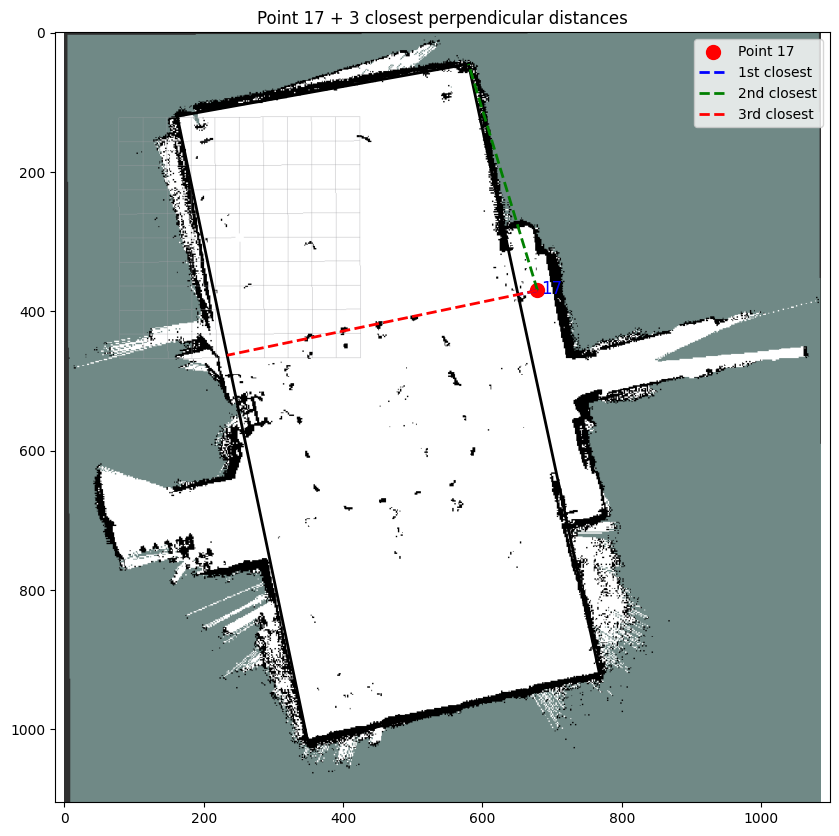

In [37]:
# --- SELECT POINT 17 ---
pt = points[15] # Point 16

# Compute distances to all 4 walls
dist_list = []
proj_list = []
for s, e in walls_ordered:
    d, pr = point_to_segment_distance(pt, s, e)
    dist_list.append(d)
    proj_list.append(pr)

dist_list = np.array(dist_list)
proj_list = np.array(proj_list)

# Get 3 closest walls
closest = np.argsort(dist_list)[:3]

# --- Convert to meters (using your scale) ---
closest_m = dist_list[closest].copy()
closest_m[0] *= scale_x
closest_m[1] *= scale_y
closest_m[2] *= scale_x  # or scale_y depending on orientation if needed
closest_m = np.round(closest_m, 3)

print("Three closest wall distances from Point 17 [m]:", closest_m)

# --- PLOT ---
plt.figure(figsize=(10,10))
plt.imshow(img)

# Draw walls
for start, end in walls_ordered:
    plt.plot([start[0], end[0]], [start[1], end[1]], 'k-', linewidth=2)

# Draw point 17
plt.scatter(pt[0], pt[1], c='red', s=100, label="Point 17")
plt.text(pt[0]+5, pt[1]+5, "17", color='blue', fontsize=12)

# Draw 3 perpendicular lines
colors = ['blue', 'green', 'red'] #blue is shortest, green is middle, red is longest
labels = ['1st closest', '2nd closest', '3rd closest']

for i, idx in enumerate(closest):
    pr = proj_list[idx]
    plt.plot([pt[0], pr[0]], [pt[1], pr[1]], color=colors[i], linestyle='--', linewidth=2, label=labels[i])

plt.axis('equal')
plt.legend()
plt.title("Point 17 + 3 closest perpendicular distances")
plt.show()



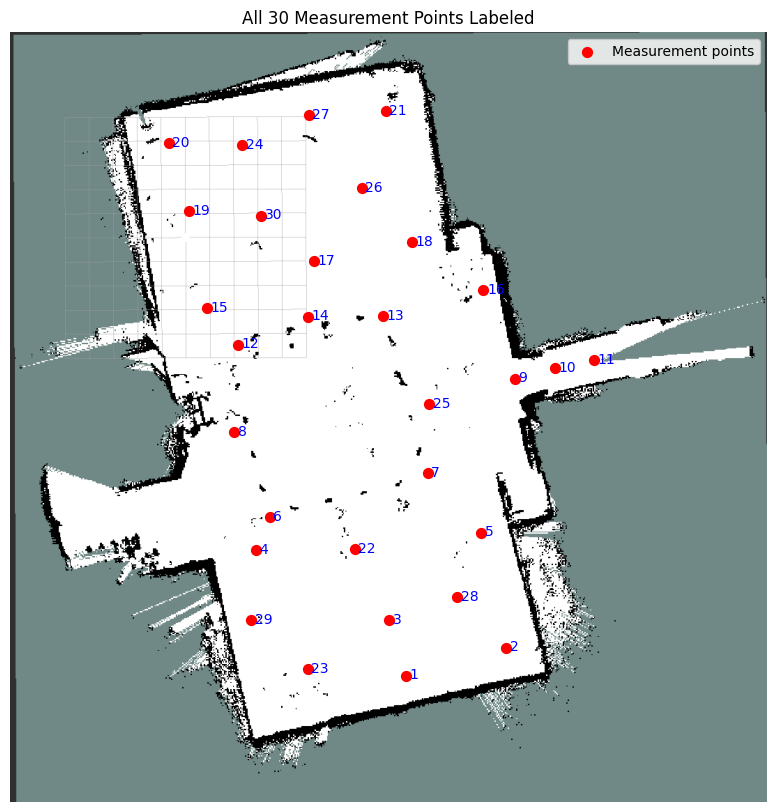

In [38]:
# Plot all 30 points
plt.figure(figsize=(10,10))
plt.imshow(img)

# Scatter plot
plt.scatter(points[:,0], points[:,1], c='red', s=50, label='Measurement points')

# Label each point with its index (1–30)
for idx, pt in enumerate(points, start=1):
    plt.text(pt[0] + 5, pt[1] + 5, str(idx), color='blue', fontsize=10)

plt.title("All 30 Measurement Points Labeled")
plt.axis('off')
plt.legend()
plt.show()


In [39]:
import numpy as np
import cv2
from matplotlib.path import Path
import matplotlib.pyplot as plt

# --- 1) Hall corners and hole ---
walls_corners = np.array([
    [350, 1020],
    [768, 920],
    [580, 45],
    [162, 120]
], dtype=np.int32)

hole_points = np.array([
    [372, 696],
    [599, 633],
    [535, 407],
    [326, 448]
], dtype=np.int32)
hole_path = Path(hole_points)

# --- 2) Measurement points (30 points) ---
measurement_points = np.array([
    [568, 923],[712, 883],[544, 844],[352, 743],[676, 718],
    [372, 696],[599, 633],[321, 574],[724, 497],[782, 482],
    [838, 470],[326, 448],[535, 407],[427, 408],[282, 396],
    [679, 370],[436, 328],[577, 301],[257, 257],[227, 159],
    [539, 113],[494, 742],[427, 914],[333, 162],[601, 533],
    [504, 223],[428, 119],[641, 811],[346, 844],[360, 263]
], dtype=np.int32)

# --- 3) Create hall mask ---
img_height = walls_corners[:,1].max() + 20
img_width  = walls_corners[:,0].max() + 20
mask = np.zeros((img_height, img_width), dtype=np.uint8)
cv2.fillPoly(mask, [walls_corners], 1)
cv2.fillPoly(mask, [hole_points], 0)
mask = mask.astype(bool)

# --- 4) Define uniform 40x40 grid over bounding box ---
nx, ny = 30, 30
ys, xs = np.where(mask)
x_min, x_max = xs.min(), xs.max()
y_min, y_max = ys.min(), ys.max()
x_lin = np.linspace(x_min, x_max, nx)
y_lin = np.linspace(y_min, y_max, ny)
xx, yy = np.meshgrid(x_lin, y_lin)
grid_points = np.vstack([xx.ravel(), yy.ravel()]).T.astype(np.int32)

# --- 5) Keep points inside hall and outside hole ---
inside_mask = np.array([mask[y, x] for x, y in grid_points])
no_hole_mask = np.array([not hole_path.contains_point((x, y)) for x, y in grid_points])
valid_grid_points = grid_points[inside_mask & no_hole_mask]

# --- 6) Assign measurement points to grid cells ---
# Pick nearest available valid grid points for each measurement
selected_grid_points = []
remaining_grid = valid_grid_points.tolist()

for mp in measurement_points:
    # compute distance to remaining grid
    dists = np.linalg.norm(np.array(remaining_grid) - mp, axis=1)
    idx = np.argmin(dists)
    selected = remaining_grid.pop(idx)
    selected_grid_points.append(selected)

selected_grid_points = np.array(selected_grid_points)

# --- 7) Fill the rest of the grid ---
remaining_needed = nx*ny - selected_grid_points.shape[0]
if remaining_needed > len(remaining_grid):
    raise ValueError("Not enough valid points to fill the full grid.")

rest_grid_points = np.array(remaining_grid[:remaining_needed])
final_grid = np.vstack([rest_grid_points, selected_grid_points])

# Optional: shuffle so measurement points are not all at the end
np.random.seed(0)
np.random.shuffle(final_grid)

# --- 8) Visualization ---
plt.figure(figsize=(10,10))
plt.imshow(np.zeros_like(mask), cmap='gray')
plt.scatter(final_grid[:,0], final_grid[:,1], s=15, c='lightgray', label='Grid points')
plt.scatter(measurement_points[:,0], measurement_points[:,1], s=50, c='red', label='Measurement points')
for i, pt in enumerate(measurement_points, start=1):
    plt.text(pt[0]+3, pt[1]+3, str(i), color='blue', fontsize=9)
plt.title("40x40 Uniform Grid with 30 Measurement Points Inside Hall, Hole Removed")
plt.axis('off')
plt.legend()
plt.show()

print("Final grid shape:", final_grid.shape)
print("Number of grid points:", final_grid.shape[0])


ValueError: Not enough valid points to fill the full grid.

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# ----------------------------
# 0) Assume `img` is loaded already (the hall image)
# Example: img = cv2.imread('R1_hall.png')
# Convert to grayscale to create mask if needed:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
mask = img_gray != grey_value  # True = hall area, False = background
# For this cell, we simulate a mask for demonstration purposes:
# ----------------------------
# Example mask placeholder (replace with your real mask)
mask = np.ones((1024, 1024), dtype=bool)  # full hall, all True

# ----------------------------
# 1) Your 30 measurement points
# ----------------------------
measurement_points = np.array([
    [568, 923],[712, 883],[544, 844],[352, 743],[676, 718],
    [372, 696],[599, 633],[321, 574],[724, 497],[782, 482],
    [838, 470],[326, 448],[535, 407],[427, 408],[282, 396],
    [679, 370],[436, 328],[577, 301],[257, 257],[227, 159],
    [539, 113],[494, 742],[427, 914],[333, 162],[601, 533],
    [504, 223],[428, 119],[641, 811],[346, 844],[360, 263]
], dtype=np.int32)

# ----------------------------
# 2) Hall contour
# ----------------------------
contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
hall_contour = max(contours, key=cv2.contourArea)
hall_contour_int = hall_contour.astype(np.int32).reshape(-1,1,2)

# Bounding box of hall
x_min = np.min(hall_contour_int[:,:,0])
x_max = np.max(hall_contour_int[:,:,0])
y_min = np.min(hall_contour_int[:,:,1])
y_max = np.max(hall_contour_int[:,:,1])

# ----------------------------
# 3) Create 40x40 grid inside bounding box
# ----------------------------
nx, ny = 40, 40
x_lin = np.linspace(x_min, x_max, nx)
y_lin = np.linspace(y_min, y_max, ny)
xx, yy = np.meshgrid(x_lin, y_lin)
grid_points = np.vstack([xx.ravel(), yy.ravel()]).T.astype(np.int32)

# ----------------------------
# 4) Keep points inside hall contour
# ----------------------------
inside_mask = np.array([
    cv2.pointPolygonTest(hall_contour_int, (int(x), int(y)), False) >= 0
    for x, y in grid_points
])
valid_grid_points = grid_points[inside_mask]

# ----------------------------
# 5) Force measurement points to be part of the grid
# ----------------------------
# Remove duplicates first
valid_grid_points = np.array([
    pt for pt in valid_grid_points if not any(np.all(pt == mp) for mp in measurement_points)
])
final_grid = np.vstack([valid_grid_points, measurement_points])

# ----------------------------
# 6) Visualize
# ----------------------------
plt.figure(figsize=(10,10))
plt.imshow(np.zeros_like(mask), cmap='gray')  # background
plt.scatter(final_grid[:,0], final_grid[:,1], s=15, c='lightgray', label='Grid points')
plt.scatter(measurement_points[:,0], measurement_points[:,1], s=50, c='red', label='Measurement points')
for i, pt in enumerate(measurement_points, start=1):
    plt.text(pt[0]+3, pt[1]+3, str(i), color='blue', fontsize=9)
plt.title("40x40 Grid over Reactor Hall (30 measurement points fixed)")
plt.axis('off')
plt.legend()
plt.show()

print("Total grid points:", final_grid.shape[0])


error: OpenCV(4.12.0) :-1: error: (-5:Bad argument) in function 'cvtColor'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


Map size: 1086x1105 pixels


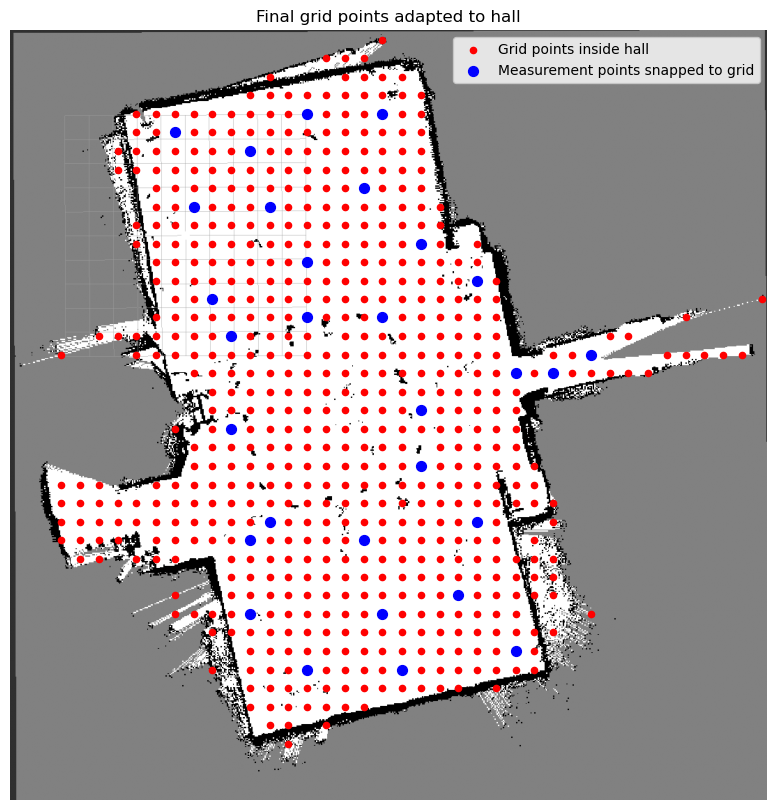

Final grid points: 648
Measurement point 1: [568 923] -> Closest grid point: [562 918]
Measurement point 2: [712 883] -> Closest grid point: [725 891]
Measurement point 3: [544 844] -> Closest grid point: [534 838]
Measurement point 4: [352 743] -> Closest grid point: [344 731]
Measurement point 5: [676 718] -> Closest grid point: [670 705]
Measurement point 6: [372 696] -> Closest grid point: [372 705]
Measurement point 7: [599 633] -> Closest grid point: [589 625]
Measurement point 8: [321 574] -> Closest grid point: [317 572]
Measurement point 9: [724 497] -> Closest grid point: [725 492]
Measurement point 10: [782 482] -> Closest grid point: [779 492]
Measurement point 11: [838 470] -> Closest grid point: [833 466]
Measurement point 12: [326 448] -> Closest grid point: [317 439]
Measurement point 13: [535 407] -> Closest grid point: [534 412]
Measurement point 14: [427 408] -> Closest grid point: [426 412]
Measurement point 15: [282 396] -> Closest grid point: [290 386]
Measurement

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# --- 1) Load map ---
map_path = r"C:\Users\annal\OneDrive\Desktop\KTH_2\2 Period\project course\Map_of_R1_Hall.png"
img = Image.open(map_path).convert("L")  # convert to grayscale
gray = np.array(img)
height, width = gray.shape
print(f"Map size: {width}x{height} pixels")

# --- 2) Create hall mask (True = white / walkable area) ---
mask = gray > 200  # adjust threshold to match hall brightness

# --- 3) 30 measurement points ---
measurement_points = np.array([
    [568, 923],[712, 883],[544, 844],[352, 743],[676, 718],
    [372, 696],[599, 633],[321, 574],[724, 497],[782, 482],
    [838, 470],[326, 448],[535, 407],[427, 408],[282, 396],
    [679, 370],[436, 328],[577, 301],[257, 257],[227, 159],
    [539, 113],[494, 742],[427, 914],[333, 162],[601, 533],
    [504, 223],[428, 119],[641, 811],[346, 844],[360, 263]
], dtype=np.int32)

# --- 4) Bounding box of hall ---
y_idx, x_idx = np.where(mask)
x_min, x_max = x_idx.min(), x_idx.max()
y_min, y_max = y_idx.min(), y_idx.max()

# --- 5) Create dense grid over bounding box ---
nx, ny = 40, 40
x_lin = np.linspace(x_min, x_max, nx)
y_lin = np.linspace(y_min, y_max, ny)
xx, yy = np.meshgrid(x_lin, y_lin)
grid_points = np.vstack([xx.ravel(), yy.ravel()]).T.astype(np.int32)

# --- 6) Keep only points inside hall ---
grid_points = np.array([[x,y] for x,y in grid_points if mask[y,x]])

# --- 7) Snap measurement points to nearest grid points ---
from scipy.spatial import cKDTree
tree = cKDTree(grid_points)
_, idx = tree.query(measurement_points)  # find nearest grid points
snapped_measurements = grid_points[idx]  # measurement points now coincide with grid points

# --- 8) Remove snapped points from grid to avoid duplicates ---
def remove_near_points(grid, points, threshold=1):
    mask_arr = np.ones(len(grid), dtype=bool)
    for p in points:
        dists = np.linalg.norm(grid - p, axis=1)
        mask_arr[dists < threshold] = False
    return grid[mask_arr]

remaining_grid = remove_near_points(grid_points, snapped_measurements)

# --- 9) Final grid: snapped measurements + remaining points ---
final_grid = np.vstack([snapped_measurements, remaining_grid])

# --- 10) New mask with only final grid points ---
new_mask = np.zeros_like(mask, dtype=bool)
for x, y in final_grid:
    new_mask[y, x] = True

# --- 11) Visualization ---
plt.figure(figsize=(10,10))
plt.imshow(gray, cmap='gray')
plt.scatter(final_grid[:,0], final_grid[:,1], s=20, c='red', label='Grid points inside hall')
plt.scatter(snapped_measurements[:,0], snapped_measurements[:,1], s=50, c='blue', label='Measurement points snapped to grid')
plt.title("Final grid points adapted to hall")
plt.axis('off')
plt.legend()
plt.show()

#plt.figure(figsize=(8,8))
#plt.imshow(new_mask, cmap='gray')
#plt.title("New mask: only final grid points")
#plt.axis('off')
#plt.show()

print("Final grid points:", final_grid.shape[0])


# Print each measurement point and its corresponding closest grid point
for i, (meas, snapped) in enumerate(zip(measurement_points, snapped_measurements)):
    print(f"Measurement point {i+1}: {meas} -> Closest grid point: {snapped}")


In [ ]:
# Print in chunks of 20
for i in range(0, len(final_grid), 20):
    chunk = final_grid[i:i+20]
    print(chunk)

# --- 导出 final_grid 到 CSV 文件 ---



[[562 918]
 [725 891]
 [534 838]
 [344 731]
 [670 705]
 [372 705]
 [589 625]
 [317 572]
 [725 492]
 [779 492]
 [833 466]
 [317 439]
 [534 412]
 [426 412]
 [290 386]
 [670 359]
 [426 333]
 [589 306]
 [263 253]
 [236 146]]
[[534 120]
 [507 731]
 [426 918]
 [344 173]
 [589 545]
 [507 226]
 [426 120]
 [643 811]
 [344 838]
 [372 253]
 [534  14]
 [453  40]
 [480  40]
 [507  40]
 [372  67]
 [480  67]
 [507  67]
 [534  67]
 [562  67]
 [344  93]]
[[372  93]
 [399  93]
 [426  93]
 [453  93]
 [480  93]
 [507  93]
 [534  93]
 [562  93]
 [589  93]
 [181 120]
 [209 120]
 [236 120]
 [263 120]
 [290 120]
 [317 120]
 [344 120]
 [372 120]
 [399 120]
 [453 120]
 [480 120]]
[[507 120]
 [562 120]
 [589 120]
 [181 146]
 [209 146]
 [263 146]
 [290 146]
 [317 146]
 [344 146]
 [372 146]
 [399 146]
 [426 146]
 [453 146]
 [480 146]
 [507 146]
 [534 146]
 [562 146]
 [589 146]
 [154 173]
 [181 173]]
[[209 173]
 [236 173]
 [263 173]
 [290 173]
 [317 173]
 [372 173]
 [399 173]
 [426 173]
 [453 173]
 [480 173]
 [507 

In [ ]:
point_to_find = np.array([534, 412])

# Check where it occurs
matches = np.all(final_grid == point_to_find, axis=1)
indices = np.where(matches)[0]

print("Indices of [534, 412] in final_grid:", indices)

import pandas as pd

# 创建 DataFrame
final_grid_df = pd.DataFrame(final_grid, columns=["X", "Y"])

# 保存到 CSV 文件
output_csv_path = "final_grid_points.csv"
final_grid_df.to_csv(output_csv_path, index=False)

print(f"Final grid points saved to {output_csv_path}")


Indices of [534, 412] in final_grid: [12]


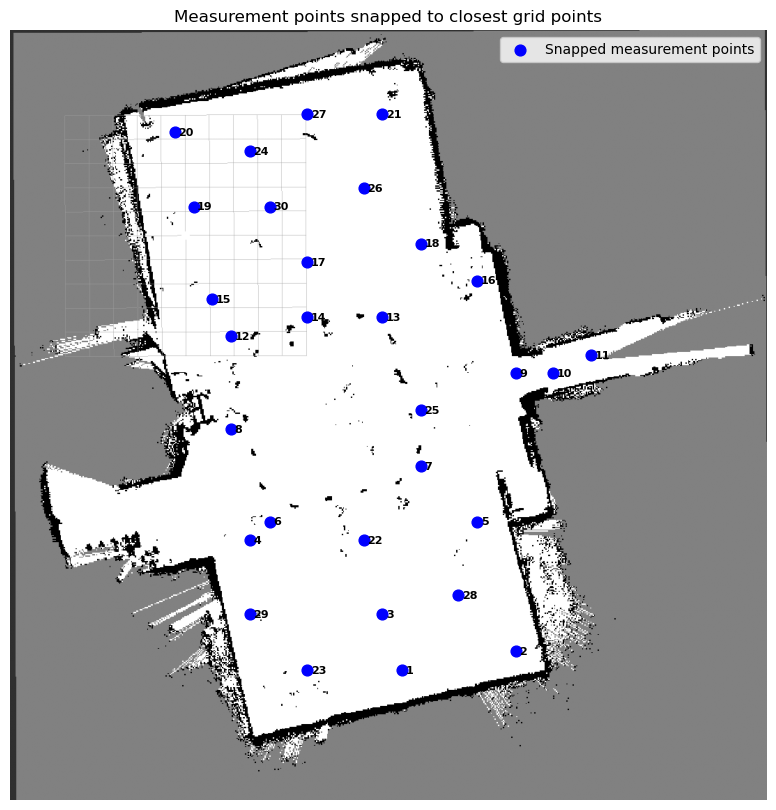

In [ ]:
import matplotlib.pyplot as plt

# --- 1) New array of snapped grid points ---
snapped_points_array = snapped_measurements.copy()  # already contains the closest grid points

# --- 2) Plot map with points and indices ---
plt.figure(figsize=(10,10))
plt.imshow(gray, cmap='gray')
plt.scatter(snapped_points_array[:,0], snapped_points_array[:,1], s=60, c='blue', label='Snapped measurement points')

# Add indices 1 to 30
for i, (x, y) in enumerate(snapped_points_array, start=1):
    plt.text(x+5, y+5, str(i), color='black', fontsize=8, weight='bold')

plt.title("Measurement points snapped to closest grid points")
plt.axis('off')
plt.legend()
plt.show()
